In [1]:
# 2017013207 电商1701 丁泽锋
# 2017013225 电商1701 杨丹妮
# 时间：2020-06-01
#导入Pyspark框架
import os
import sys
spark_name = os.environ.get('SPARK_HOME',None)
if not spark_name:
    raise ValueErrorError('spark环境没有配置好')
sys.path.insert(0,os.path.join(spark_name,'python'))
sys.path.insert(0,os.path.join(spark_name,'python/lib/py4j-0.10.7-src.zip'))
exec(open(os.path.join(spark_name,'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.5
      /_/

Using Python version 3.5.2 (default, Jul  5 2016 11:41:13)
SparkSession available as 'spark'.


In [9]:
# 将数据导入并且查看
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('learn_regression').master('local[1]').getOrCreate()
# 数据导入
df_train = spark.read.csv('D:/code/Spark/data/train.csv', header=True, inferSchema=True, encoding='utf-8')
df_test = spark.read.csv('D:/code/Spark/data/test.csv', header=True, inferSchema=True, encoding='utf-8')
# 表合并
from pyspark.sql.functions import lit
df_test = df_test.withColumn('medv', lit(22.77))
df0 = df_train.union(df_test).sort('ID')



In [4]:
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')
# GBDT
from sklearn.ensemble import GradientBoostingRegressor
# XGBoost
import xgboost as xgb
# LightGBM
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#载入数据
data_train = pd.read_csv('D:/code/Spark/data/train.csv')
data_train['Type'] = 'Train'
data_test = pd.read_csv('D:/code/Spark/data/test.csv')
data_test['Type'] = 'Test'
data_all = pd.concat([data_train, data_test], ignore_index=True)

# 总体情况
print(data_train.info())
print(data_train.describe())
data_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 16 columns):
ID         333 non-null int64
crim       333 non-null float64
zn         333 non-null float64
indus      333 non-null float64
chas       333 non-null int64
nox        333 non-null float64
rm         333 non-null float64
age        333 non-null float64
dis        333 non-null float64
rad        333 non-null int64
tax        333 non-null int64
ptratio    333 non-null float64
black      333 non-null float64
lstat      333 non-null float64
medv       333 non-null float64
Type       333 non-null object
dtypes: float64(11), int64(4), object(1)
memory usage: 41.7+ KB
None
               ID        crim          zn       indus        chas         nox  \
count  333.000000  333.000000  333.000000  333.000000  333.000000  333.000000   
mean   250.951952    3.360341   10.689189   11.293483    0.060060    0.557144   
std    147.859438    7.352272   22.674762    6.998123    0.237956    0.114955   

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,Type
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,Train
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,Train
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,Train
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,Train
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9,Train


In [6]:
numerical_feas=['ID','crim','zn','indus','chas',
    'nox','rm','age','dis','rad',
    'tax','ptratio','black','lstat']
#查看有无缺失
def missing_values(df):
    alldata_na = pd.DataFrame(df.isnull().sum(), columns={'missingNum'})
    alldata_na['existNum'] = len(df) - alldata_na['missingNum']
    alldata_na['sum'] = len(df)
    alldata_na['missingRatio'] = alldata_na['missingNum']/len(df)*100
    alldata_na['dtype'] = df.dtypes
    #ascending：默认True升序排列；False降序排列
    alldata_na = alldata_na[alldata_na['missingNum']>0].reset_index().sort_values(by=['missingNum','index'],ascending=[False,True])
    alldata_na.set_index('index',inplace=True)
    return alldata_na

missing_values(data_train)


,missingNum,existNum,sum,missingRatio,dtype
index,,,,,


In [7]:
#是否有单调特征列
def incresing(vals):
    cnt = 0
    len_ = len(vals)
    for i in range(len_-1):
        if vals[i+1] > vals[i]:
            cnt += 1
    return cnt

fea_cols = [col for col in data_train.columns]
for col in fea_cols:
    cnt = incresing(data_train[col].values)
    if cnt / data_train.shape[0] >= 0.55:
        print('单调特征：',col)
        print('单调特征值个数：', cnt)
        print('单调特征值比例：', cnt / data_train.shape[0])

单调特征： ID
单调特征值个数： 332
单调特征值比例： 0.996996996996997


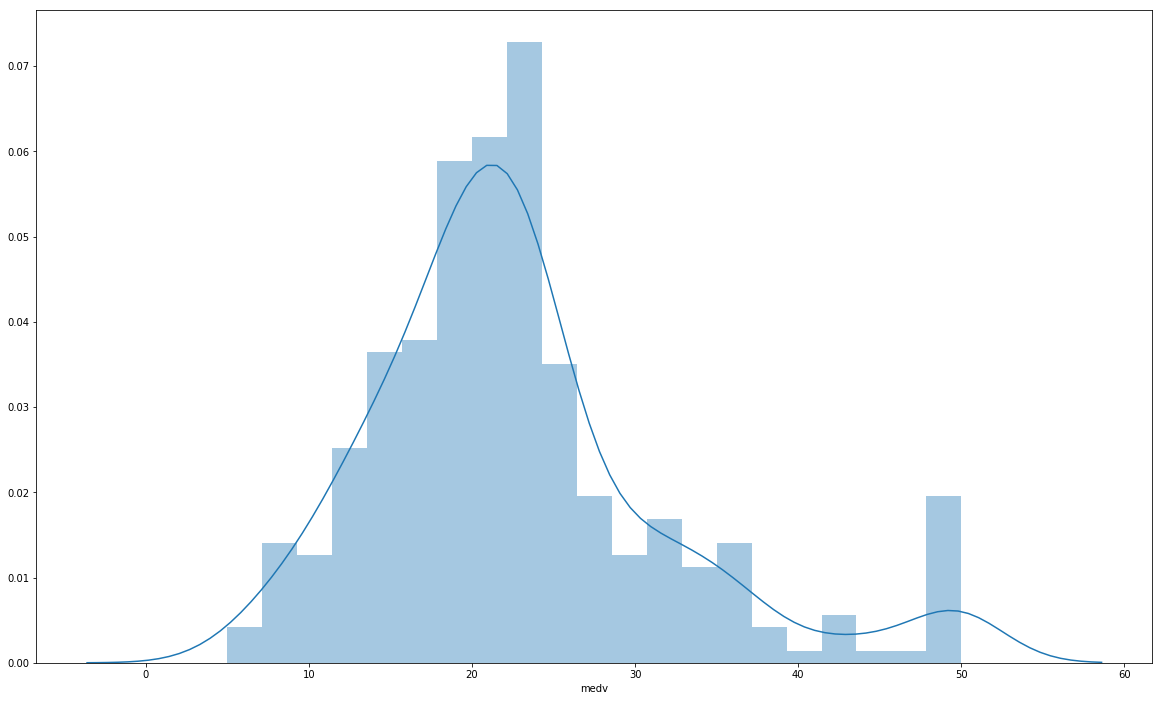

In [8]:
%matplotlib inline
# Labe 分布
fig,axes = plt.subplots(1,1,figsize=(20,5))
#创建画布
fig.set_size_inches(20,12)
#设置图形的尺寸
sns.distplot(data_train['medv'])

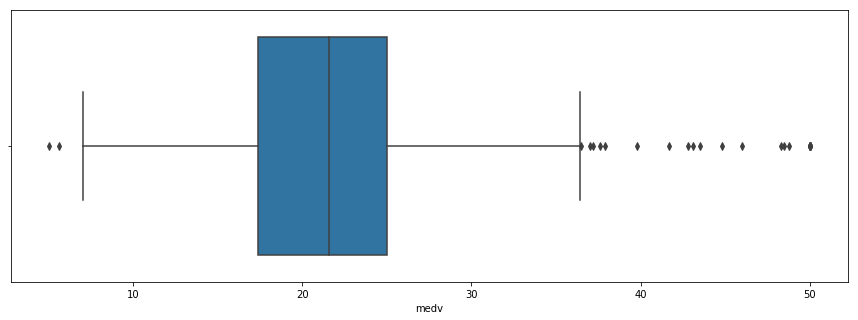

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import pickle
import multiprocessing
from sklearn.preprocessing import StandardScaler
ss = StandardScaler() 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression,LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

# 房价分布箱线图
plt.figure(figsize=(15,5))
sns.boxplot(data_train.medv),
plt.show()

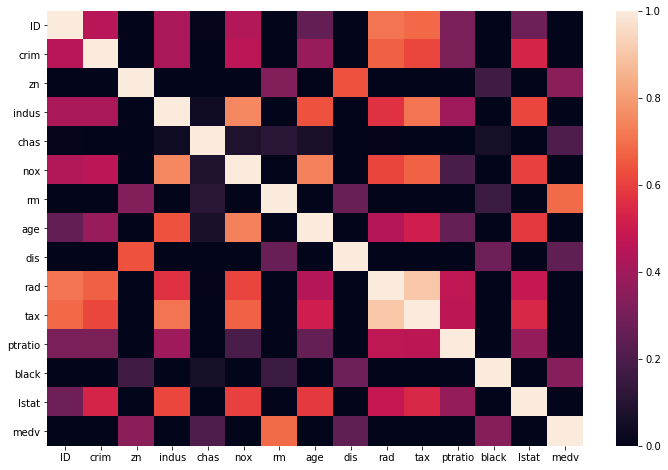

In [13]:
import seaborn as sns
fig=plt.figure(figsize=(12,8),dpi=600)
sns.heatmap(data_train.corr(),annot = False,vmin = 0, vmax = 1)

In [18]:
#决策树回归算法
from pyspark.ml.feature import VectorAssembler
def feature_converter(df):
    vecAss = VectorAssembler(inputCols=df0.columns[1:-1], outputCol='features')
    df_va = vecAss.transform(df)
    return df_va

train_data, test_data = feature_converter(df0).select(['features', 'medv']).randomSplit([7.0, 3.0], 101)


from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(maxDepth=5, varianceCol="variance", labelCol='medv')
dt_model = dt.fit(train_data)

dt_model.featureImportances

result = dt_model.transform(test_data)
result.show(3)

from pyspark.ml.evaluation import RegressionEvaluator
dt_evaluator = RegressionEvaluator(labelCol='medv', metricName="rmse", predictionCol='prediction')
rmse = dt_evaluator.evaluate(result)
print('决策树回归，测试数据的均方根误差（rmse）:{}'.format(rmse))

+--------------------+-----+------------------+------------------+
|            features| medv|        prediction|          variance|
+--------------------+-----+------------------+------------------+
|[0.03237,0.0,2.18...| 33.4| 34.12833333333334|29.509013888888756|
|[0.08829,12.5,7.8...| 22.9|21.195135135135136| 4.446162819576342|
|[0.14455,12.5,7.8...|22.77|22.425999999999995|0.5578440000003866|
+--------------------+-----+------------------+------------------+
only showing top 3 rows

决策树回归，测试数据的均方根误差（rmse）:6.555920141221407


In [19]:
#梯度提升树回归 （Gradient-boosted tree regression）
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(maxIter=10, labelCol='medv', maxDepth=3)
gbt_model = gbt.fit(train_data)
result = gbt_model.transform(test_data)
result.show(3)
from pyspark.ml.evaluation import RegressionEvaluator
gbt_evaluator = RegressionEvaluator(labelCol='medv', metricName="rmse", predictionCol='prediction')
rmse = gbt_evaluator.evaluate(result)
print('梯度提升树回归，测试数据的均方根误差（rmse）:{}'.format(rmse))

+--------------------+-----+------------------+
|            features| medv|        prediction|
+--------------------+-----+------------------+
|[0.03237,0.0,2.18...| 33.4| 31.98716729056085|
|[0.08829,12.5,7.8...| 22.9|22.254258637918248|
|[0.14455,12.5,7.8...|22.77|20.066468254729102|
+--------------------+-----+------------------+
only showing top 3 rows

梯度提升树回归，测试数据的均方根误差（rmse）:5.624145397622545


In [20]:
#随机森林回归
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(numTrees=10, maxDepth=5, seed=101, labelCol='medv')
rf_model = rf.fit(train_data)
result = rf_model.transform(test_data)
result.show(3)
from pyspark.ml.evaluation import RegressionEvaluator
rf_evaluator = RegressionEvaluator(labelCol='medv', metricName="rmse", predictionCol='prediction')
rmse = rf_evaluator.evaluate(result)
print('随机森林回归，测试数据的均方根误差（rmse）:{}'.format(rmse))

+--------------------+-----+------------------+
|            features| medv|        prediction|
+--------------------+-----+------------------+
|[0.03237,0.0,2.18...| 33.4| 30.12804440796982|
|[0.08829,12.5,7.8...| 22.9|21.338106353716338|
|[0.14455,12.5,7.8...|22.77|19.764914032872827|
+--------------------+-----+------------------+
only showing top 3 rows

随机森林回归，测试数据的均方根误差（rmse）:5.268739233773331


In [23]:
#线性回归（LinearRegression）
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(maxIter=10, elasticNetParam=0.8, regParam=0.3, labelCol='medv')
lr_model = lr.fit(train_data)
# 模型指标
trainingSummary = lr_model.summary
result = lr_model.transform(test_data)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(labelCol='medv', metricName="r2", predictionCol='prediction')
test_evaluation = lr_model.evaluate(test_data)
print('线性回归，测试数据的均方根误差（rmse）:{:.3}'.format(test_evaluation.rootMeanSquaredError))

线性回归，测试数据的均方根误差（rmse）:5.7
